In [1]:
# Restricted Boltzmann Machine (RBM)

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess MNIST 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize images
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [3]:
# Define RBM
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob, torch.bernoulli(prob)

    def sample_v(self, h):
        prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob, torch.bernoulli(prob)

    def forward(self, v):
        h_prob, h_sample = self.sample_h(v)
        v_prob, v_sample = self.sample_v(h_sample)
        return v_prob, v_sample


In [4]:
# Train RBM 
n_visible = 28 * 28
n_hidden = 128
rbm = RBM(n_visible, n_hidden)

optimizer = torch.optim.Adam(rbm.parameters(), lr=0.01)
num_epochs = 5
recon_errors = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        v0 = images.view(-1, n_visible)
        v0 = v0.bernoulli()  # ensure binary input

        # Positive phase
        h_prob, h_sample = rbm.sample_h(v0)

        # Negative phase (reconstruction)
        v_prob, v_sample = rbm.sample_v(h_sample)
        h_prob_neg, _ = rbm.sample_h(v_sample)

        # Contrastive Divergence update
        pos_grad = torch.matmul(h_prob.t(), v0)
        neg_grad = torch.matmul(h_prob_neg.t(), v_sample)

        rbm.W.grad = -(pos_grad - neg_grad) / v0.size(0)
        rbm.v_bias.grad = -torch.mean(v0 - v_sample, dim=0)
        rbm.h_bias.grad = -torch.mean(h_prob - h_prob_neg, dim=0)
        optimizer.step()
        optimizer.zero_grad()

        loss = torch.mean((v0 - v_prob) ** 2)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    recon_errors.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Reconstruction Error: {avg_loss:.4f}")


Epoch [1/5], Reconstruction Error: 0.0388
Epoch [2/5], Reconstruction Error: 0.0281
Epoch [3/5], Reconstruction Error: 0.0255
Epoch [4/5], Reconstruction Error: 0.0242
Epoch [5/5], Reconstruction Error: 0.0235


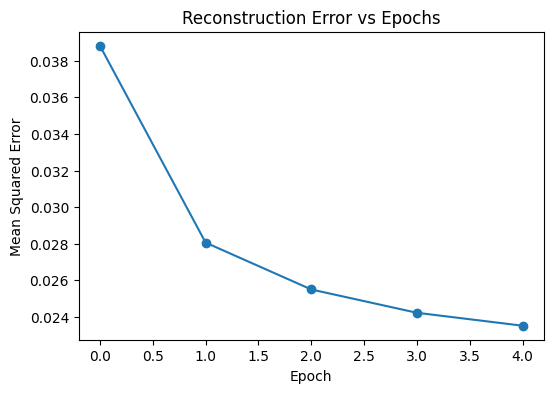

In [5]:
# Plot reconstruction error 
plt.figure(figsize=(6,4))
plt.plot(recon_errors, marker='o')
plt.title("Reconstruction Error vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.show()


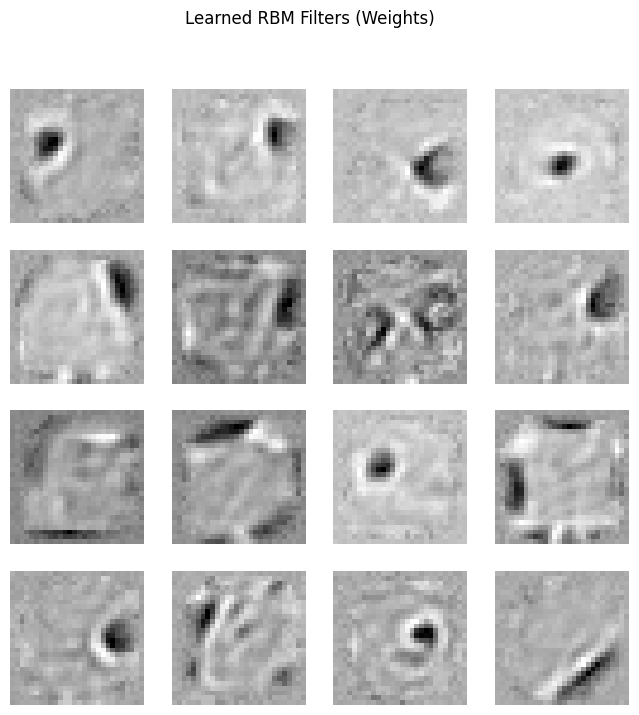

In [6]:
# Visualize learned filters 
with torch.no_grad():
    weights = rbm.W.view(n_hidden, 1, 28, 28)
    plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(weights[i][0].detach().cpu(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Learned RBM Filters (Weights)")
    plt.show()


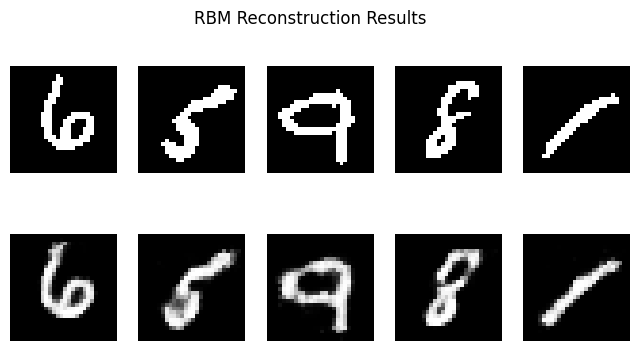

In [7]:
# Reconstruct sample images
dataiter = iter(train_loader)
images, _ = next(dataiter)
v = images.view(-1, n_visible)
v_prob, v_sample = rbm(v)
v_recon = v_prob.view(-1, 1, 28, 28)

plt.figure(figsize=(8,4))
for i in range(5):
    # Original
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original")

    # Reconstructed
    plt.subplot(2, 5, i+6)
    plt.imshow(v_recon[i][0].detach(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Reconstructed")

plt.suptitle("RBM Reconstruction Results")
plt.show()